**This code is used to make a compound ray, the method is from `Trident`**, some basic code is from `yt`, the data is from `IllustrisTNG`

Made by Shulan Yan at 2022.03.23 09:32

**Some useful webpage**

- 1.Yt project : https://yt-project.org/
- 2.Trident project : http://trident-project.org/
- 3.TNG project : https://www.tng-project.org/

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import yt
import os
import functools

from yt.frontends.ytdata.utilities import save_as_dataset
from yt.utilities.cosmology import Cosmology
from yt.utilities.physical_constants import c
from yt.utilities.physical_constants import speed_of_light_cgs
from yt.units.yt_array import YTArray, YTQuantity
from unyt import unyt_quantity

from trident.config import ion_table_filepath
from trident.ion_balance import atomic_number
from trident.line_database import LineDatabase, uniquify
from trident.roman import from_roman

In [2]:
def vector_length(start, end):
    """
    vector_length(start, end)

    Calculate vector length.
    """

    return np.sqrt(np.power((end - start), 2).sum())

def flatten_dict_list(data, exceptions=None):
    """
    _flatten_dict_list(data, exceptions=None)

    Flatten the list of dicts into one dict.
    """

    if exceptions is None: exceptions = []
    new_data = {}
    for datum in data:
        for field in [field for field in datum.keys() if field not in exceptions]:
            if field not in new_data:
                new_data[field] = []
            new_data[field].extend(datum[field])
    for field in new_data:
        new_data[field] = YTArray(new_data[field])
    return new_data

In [3]:
## from yt.utilities.cosmology
def deltaz_forward(z, target_distance, cosmology = Cosmology()):
    r"""Calculate deltaz corresponding to moving a comoving distance
    starting from some redshift.
    """

    d_Tolerance = 1e-4
    max_Iterations = 100

    z1 = z
    # Use Hubble's law for initial guess
    target_distance = cosmology.quan(target_distance.to("Mpccm / h"))
    v = cosmology.hubble_parameter(z) * target_distance
    v = min(v, 0.9 * c)
    dz = np.sqrt((1. + v/c) / (1. - v/c)) - 1. # special relativistic Doppler shift law
    z2 = z1 - dz
    distance1 = cosmology.quan(0.0, "Mpccm / h")
    distance2 = cosmology.comoving_radial_distance(z2, z)
    iteration = 1

    while ((np.abs(distance2 - target_distance)/distance2) > d_Tolerance):
        m = (distance2 - distance1) / (z2 - z1)
        z1 = z2
        distance1 = distance2
        z2 = ((target_distance - distance2) / m.in_units("Mpccm / h")) + z2
        distance2 = cosmology.comoving_radial_distance(z2, z)
        iteration += 1
        if (iteration > max_Iterations):
            mylog.error("deltaz_forward: Warning - max iterations " +
                        "exceeded for z = %f (delta z = %f)." %
                        (z, np.abs(z2 - z)))
            break
    return np.abs(z2 - z)

In [4]:
## from trident.ray_generator
def determine_ions_from_lines(line_database, lines):
    """
    Figure out what ions are necessary to produce the desired lines
    """
    if line_database is not None:
        line_database = LineDatabase(line_database)
        ion_list = line_database.parse_subset_to_ions(lines)
    else:
        ion_list = []
        if lines == 'all' or lines == ['all']:
            for k,v in atomic_number.items():
                for j in range(v+1):
                    ion_list.append((k, j+1))
        else:
            for line in lines:
                linen = line.split()
                if len(linen) >= 2:
                    ion_list.append((linen[0], from_roman(linen[1])))
                elif len(linen) == 1:
                    num_states = atomic_number[linen[0]]
                    for j in range(num_states+1):
                        ion_list.append((linen[0], j+1))
                else:
                    raise RuntimeError("Cannot add a blank ion.")

    return uniquify(ion_list)

def determine_fields_from_ions(ds, ion_list, fields):
    """
    Figure out what fields need to be added based on the ions present.

    Check if the number_density fields for these ions exist, and if so, add
    them to field list. If not, leave them off, as they'll be generated
    on the fly by SpectrumGenerator as long as we include the 'density',
    'temperature', and appropriate 'metallicity' fields.
    """
    for ion in ion_list:
        atom = ion[0].capitalize()
        ion_state = ion[1]
        nuclei_field = "%s_nuclei_mass_density" % atom
        metallicity_field = "%s_metallicity" % atom
        field = "%s_p%d_number_density" % (atom, ion_state-1)

        # Check to see if the ion field exists.  If so, add it to the ray.
        # If not, then append the density and the appropriate
        # metal field so one can create the ion field on the fly on the
        # ray itself.
        if ("gas", field) not in ds.derived_field_list:
            fields.append(('gas', 'density'))
            if ('gas', metallicity_field) in ds.derived_field_list:
                fields.append(('gas', metallicity_field))
            elif ('gas', nuclei_field) in ds.derived_field_list:
                fields.append(('gas', nuclei_field))
            elif atom != 'H':
                fields.append(('gas', 'metallicity'))
            else:
                # Don't need metallicity field if we're just looking
                # at hydrogen
                pass
        else:
            fields.append(("gas", field))

    return fields

In [5]:
quan = functools.partial(YTQuantity, registry=None) # Initialize the data quantity

In [6]:
## The initial parameter
z_target = 0.04
near_redshift = 0
far_redshift = near_redshift + z_target
use_peculiar_velocity = True # parameter
left_edge = np.array([0,0,0])
right_edge = np.array([75000,75000,75000])
my_random = np.random.RandomState(None)

In [7]:
print('Target Redshift:',z_target)
print('Redshift Range:',near_redshift, ',', far_redshift)
print('Left_edge:',left_edge, 'Right_edge:', right_edge)

Target Redshift: 0.04
Redshift Range: 0 , 0.04
Left_edge: [0 0 0] Right_edge: [75000 75000 75000]


In [8]:
## Read the parameter file
basepath = 'tng100-3'
snapshot_ids = ['99','91','84','78','72','67']
max_box_fraction = 1.0
simulation_parameter_filename = basepath + '/simulation.hdf5'
simulation_parameter_file = h5py.File(simulation_parameter_filename)

In [9]:
basic_parameters = dict(simulation_parameter_file['Header'].attrs.items())
Boxsize = basic_parameters['BoxSize']/1000 # in units with 'Mpc/h'
Hubble_parameter = basic_parameters['HubbleParam']
Omega_matter = basic_parameters['Omega0']
Omega_baryon = basic_parameters['OmegaBaryon']
Omega_lambda = basic_parameters['OmegaLambda']

In [10]:
print('Boxsize:', Boxsize)
print('Hubble parameter (h):', Hubble_parameter)
print('Omega_matter:', Omega_matter)
print('Omega_baryon:', Omega_baryon)
print('Omega_lambda:', Omega_lambda)

Boxsize: 75.0
Hubble parameter (h): 0.6774
Omega_matter: 0.3089
Omega_baryon: 0.0486
Omega_lambda: 0.6911


In [11]:
## calculate the distance of target

# Using the cosmology parameter of TNG
cosmology_tng = Cosmology(hubble_constant = Hubble_parameter, omega_matter = Omega_matter, omega_lambda = Omega_lambda)

distance_target = cosmology_tng.comoving_radial_distance(near_redshift, far_redshift).in_units('Mpccm/h')
unit_mpch = distance_target.units # set the unit
box_number = int(distance_target/Boxsize) + 1 # the number of boxes
distance_exceed = np.mod(distance_target.value, Boxsize) # the distance in the final box

In [12]:
print(distance_target)
print('Number of boxes:', box_number)
print('The distance of the final box:', distance_exceed)

118.7851360718415 Mpccm/h
Number of boxes: 2
The distance of the final box: 43.78513607184151


In [13]:
# create cosmology splice
snapshot_numbers = len(simulation_parameter_file['Snapshots'].keys())
cosmology_splice = []
snapshot_index = 0
for i in range(box_number):
    current_distance = Boxsize * i
    if i == box_number - 1:
        box_fraction = (distance_target.value - current_distance)/Boxsize
    else:
        box_fraction = 1
    snapshot_index = int((i+2)/4)
    snapshot_parameter = dict(simulation_parameter_file['Snapshots'][snapshot_ids[snapshot_index]]['Header'].attrs.items())
    snapshot_redshift = snapshot_parameter['Redshift']
    
    current_distance_in_mpch = quan(current_distance, unit_mpch)
    snapshot_redshift = deltaz_forward(0.0, current_distance_in_mpch, cosmology = cosmology_tng).value
    snapshot_time = cosmology_tng.t_from_z(snapshot_redshift)
    random_pos = Boxsize * my_random.random_sample(3)
    start_pos = np.array([random_pos[0],random_pos[1],0]) # Mpc/h
    end_pos = start_pos.copy()
    end_pos[2] = start_pos[2] + Boxsize*box_fraction  # Mpc/h
    output_filename = 'snapdir_0' + str(snapshot_ids[snapshot_index]) + '/snap_0' + str(snapshot_ids[snapshot_index]) + '.0.hdf5'
    filepath = os.path.join(basepath, output_filename)
    cosmology_splice.append(
        {
            "time": snapshot_time,
            "redshift": snapshot_redshift,
            "filename": filepath,
            "traversal_box_fraction": box_fraction,
            "start": start_pos,
            "end": end_pos
            }
    )
    if i == box_number - 1:
        cosmology_splice[i]['Next'] = None
    if i > 0:
        cosmology_splice[i-1]['Next'] = cosmology_splice[i]

cosmology_splice

/home/yanshulan/.local/lib/python3.7/site-packages/unyt/array.py:1779: RuntimeWarning: invalid value encountered in true_divide
  inp0.view(np.ndarray), inp1.view(np.ndarray), out=out_func, **kwargs


[{'time': unyt_quantity(4.35581745e+17, 's'),
  'redshift': array(0.),
  'filename': 'tng100-3/snapdir_099/snap_099.0.hdf5',
  'traversal_box_fraction': 1,
  'start': array([11.02599624, 30.3637637 ,  0.        ]),
  'end': array([11.02599624, 30.3637637 , 75.        ]),
  'Next': {'time': unyt_quantity(4.24452947e+17, 's'),
   'redshift': array(0.0248772),
   'filename': 'tng100-3/snapdir_099/snap_099.0.hdf5',
   'traversal_box_fraction': 0.5838018142912201,
   'start': array([72.38747416, 69.80563531,  0.        ]),
   'end': array([72.38747416, 69.80563531, 43.78513607]),
   'Next': None}},
 {'time': unyt_quantity(4.24452947e+17, 's'),
  'redshift': array(0.0248772),
  'filename': 'tng100-3/snapdir_099/snap_099.0.hdf5',
  'traversal_box_fraction': 0.5838018142912201,
  'start': array([72.38747416, 69.80563531,  0.        ]),
  'end': array([72.38747416, 69.80563531, 43.78513607]),
  'Next': None}]

In [14]:
fields = []
ds = yt.load(cosmology_splice[-1]['filename'])
if ("gas", "temperature") in ds.derived_field_list:
    fields.append(("gas", 'temperature'))

if ('gas', 'H_nuclei_density') in ds.derived_field_list:
    fields.append(('gas', 'H_nuclei_density'))

yt : [INFO     ] 2022-03-30 16:27:23,390 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2022-03-30 16:27:23,472 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2022-03-30 16:27:23,473 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2022-03-30 16:27:23,476 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-03-30 16:27:23,477 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2022-03-30 16:27:23,479 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-03-30 16:27:23,479 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2022-03-30 16:27:23,480 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2022-03-30 16:27:23,481 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2022-03-30 16:27:23,481 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2022-03-30 16:27:23,482 Parameters: hubble_consta

In [15]:
# set the ionication table
ionization_table = ion_table_filepath
ion_list = determine_ions_from_lines(line_database = None, lines = ['H I'])

In [16]:
fields = determine_fields_from_ions(ds, ion_list, fields)
for i in range(len(fields)):
    if isinstance(fields[i], str):
        fields[i] = ('gas', fields[i])
fields = uniquify(fields)

In [17]:
if (('gas', 'temperature') not in fields) and ('temperature' not in fields):
    fields.append(('gas', 'temperature'))
data_fields = fields[:]
all_fields = fields[:]
all_fields.extend(['l', 'dl', 'redshift'])
all_fields.extend(['x', 'y', 'z'])
data_fields.extend(['x', 'y', 'z'])
if use_peculiar_velocity:
    all_fields.extend(['relative_velocity_x', 'relative_velocity_y',
                        'relative_velocity_z',
                        'velocity_los', 'redshift_eff',
                        'redshift_dopp'])
    data_fields.extend(['relative_velocity_x', 'relative_velocity_y', 'relative_velocity_z'])

all_ray_storage = {}

In [18]:
from yt.utilities.parallel_tools.parallel_analysis_interface import parallel_objects, parallel_root_only

In [44]:
for my_storage, my_segment in parallel_objects(cosmology_splice,storage = all_ray_storage):
    ds = yt.load(my_segment['filename'] + str(''))
    my_start = ds.arr(my_segment['start'],'Mpccm/h')
    my_end   = ds.arr(my_segment['end'],'Mpccm/h')
    sub_segments = [[my_start, my_end]]

    sub_data = {}
    # Put supplementary data that we want communicated across
    # processors in here.
    sub_data['extra_data'] = {}
    sub_data['extra_data']['segment_redshift'] = my_segment['redshift']
    sub_data['extra_data']['unique_identifier'] = ds.unique_identifier
    for field in all_fields:
        sub_data[field] = []
    ray_length = ds.quan(0, 'code_length')
    for sub_segment in sub_segments:
        sub_ray = ds.ray(sub_segment[0], sub_segment[1])
        asort = np.argsort(sub_ray["t"])
        sub_length = vector_length(sub_ray.start_point, sub_ray.end_point)

        # redshifts derived from l values
        sub_data['l'].extend(sub_ray['t'][asort] * sub_length + ray_length)
        ray_length += sub_length
        # column densities derived from dl values
        sub_data['dl'].extend(sub_ray['dts'][asort] * sub_length)
        for field in data_fields:
            sub_data[field].extend(sub_ray[field][asort])

        if use_peculiar_velocity:
            line_of_sight = sub_segment[0] - sub_segment[1]
            line_of_sight /= ((line_of_sight**2).sum())**0.5
            sub_vel = ds.arr([sub_ray['relative_velocity_x'], sub_ray['relative_velocity_y'], sub_ray['relative_velocity_z']])
            # Line of sight velocity = vel_los
            sub_vel_los = (np.rollaxis(sub_vel, 1) * line_of_sight).sum(axis=1)
            sub_data['velocity_los'].extend(sub_vel_los[asort])
            sub_vel_mag = sub_ray['velocity_magnitude']
            cos_theta = line_of_sight.dot(sub_vel) / sub_vel_mag
            cos_theta = np.nan_to_num(cos_theta)
            # doppler redshift
            redshift_dopp = (1 + sub_vel_mag * cos_theta / speed_of_light_cgs) / np.sqrt(1 - sub_vel_mag**2 / speed_of_light_cgs**2) - 1
            sub_data['redshift_dopp'].extend(redshift_dopp[asort])
            del sub_vel, sub_vel_los, sub_vel_mag, cos_theta, redshift_dopp

        sub_ray.clear_data()
        del sub_ray, asort
        
    for key in sub_data:
        if key == "extra_data":
            continue
        sub_data[key] = ds.arr(sub_data[key]).in_cgs()

    # Get redshift for each lixel.  Assume linear relation between l
    # and z.  so z = z_start - z_range * (l / l_range)
    if my_segment['Next'] is not None:
        next_redshift = my_segment['Next']['redshift']
    else:
        next_redshift = far_redshift
    
    sub_data['redshift'] = my_segment['redshift'] - (sub_data['l'] / ray_length) * (my_segment['redshift'] - next_redshift)

    if use_peculiar_velocity:
        sub_data['redshift_eff'] = ((1 + sub_data['redshift_dopp']) * (1 + sub_data['redshift'])) - 1

    # Remove empty lixels.
    sub_dl_nonzero = sub_data['dl'].nonzero()
    for field in all_fields:
        sub_data[field] = sub_data[field][sub_dl_nonzero]
    del sub_dl_nonzero
    
    # Add to storage.
    my_storage.result = sub_data
    del ds

yt : [INFO     ] 2022-03-30 16:47:27,563 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2022-03-30 16:47:27,618 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2022-03-30 16:47:27,618 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2022-03-30 16:47:27,619 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-03-30 16:47:27,620 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2022-03-30 16:47:27,621 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-03-30 16:47:27,621 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2022-03-30 16:47:27,623 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2022-03-30 16:47:27,623 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2022-03-30 16:47:27,624 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2022-03-30 16:47:27,625 Parameters: hubble_consta

In [45]:
# Reconstruct ray data from parallel_objects storage.
all_data = [my_data for my_data in all_ray_storage.values()]
# This is now a list of segments where each one is a dictionary
# with all the fields.
all_data.sort(key=lambda a:a['extra_data']['segment_redshift'], reverse=True)

# Gather segment data to add to the light ray solution.
for segment_data, my_segment in zip(all_data, cosmology_splice):
    my_segment["unique_identifier"] = segment_data["extra_data"]["unique_identifier"]

# Flatten the list into a single dictionary containing fields
# for the whole ray.
all_data = flatten_dict_list(all_data, exceptions=['extra_data'])

data = all_data
extra_attrs = {"data_type": "yt_light_ray"}

In [46]:
ds = {}
ds["periodicity"] = (True, True, True)
ds["current_redshift"] = near_redshift

In [47]:
simulation = yt.load(cosmology_splice[-1]['filename'])
for attr in ["dimensionality", "cosmological_simulation", "domain_left_edge", "domain_right_edge", "length_unit", "time_unit"]:
    ds[attr] = getattr(simulation, attr)
    if simulation.cosmological_simulation:
        for attr in ["omega_lambda", "omega_matter","hubble_constant"]:
            ds[attr] = getattr(cosmology_tng, attr)
    ds["current_time"] = cosmology_tng.t_from_z(ds["current_redshift"])
    if isinstance(ds["hubble_constant"], YTArray):
        ds["hubble_constant"] = ds["hubble_constant"].to("100*km/(Mpc*s)").d
    extra_attrs["unit_registry_json"] = simulation.unit_registry.to_json()

yt : [INFO     ] 2022-03-30 16:54:30,852 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2022-03-30 16:54:30,909 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2022-03-30 16:54:30,910 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2022-03-30 16:54:30,911 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-03-30 16:54:30,911 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2022-03-30 16:54:30,913 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-03-30 16:54:30,913 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2022-03-30 16:54:30,914 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2022-03-30 16:54:30,914 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2022-03-30 16:54:30,915 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2022-03-30 16:54:30,915 Parameters: hubble_consta

In [48]:
field_types = dict([(field, "grid") for field in sub_data.keys()])

In [49]:
if 'temperature' in data: f = 'temperature'
if ('gas', 'temperature') in data: f = ('gas', 'temperature')
if 'temperature' in data or ('gas', 'temperature') in data:
    mask = data[f] > 0
    if not np.any(mask):
        raise RuntimeError(
            "No zones along light ray with nonzero %s. "
            "Please modify your light ray trajectory." % (f,))
    for key in data.keys():
        data[key] = data[key][mask]

In [50]:
list(data.keys())

[('gas', 'temperature'),
 ('gas', 'H_nuclei_density'),
 ('gas', 'H_p0_number_density'),
 'l',
 'dl',
 'redshift',
 'x',
 'y',
 'z',
 'relative_velocity_x',
 'relative_velocity_y',
 'relative_velocity_z',
 'velocity_los',
 'redshift_eff',
 'redshift_dopp']

save the file as a `hdf5` file

In [51]:
filename = 'test2.h5'

In [52]:
save_as_dataset(ds, filename, data, field_types=field_types,extra_attrs=extra_attrs)

yt : [INFO     ] 2022-03-30 16:54:35,111 Saving field data to yt dataset: test2.h5.


'test2.h5'

Use `Trident` to make mock spectrum

In [1]:
import trident as tri

In [27]:
# make mock spectra
sg = tri.SpectrumGenerator('COS')
sg.make_spectrum('test2.h5', lines = ["Ly a"])

yt : [INFO     ] 2022-03-30 19:48:35,779 Setting instrument to COS
yt : [INFO     ] 2022-03-30 19:48:35,965 Parameters: current_time              = 4.3558174518095616e+17 s
yt : [INFO     ] 2022-03-30 19:48:35,966 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2022-03-30 19:48:35,967 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2022-03-30 19:48:35,968 Parameters: domain_right_edge         = [75000. 75000. 75000.] code_length
yt : [INFO     ] 2022-03-30 19:48:35,969 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-03-30 19:48:35,970 Parameters: current_redshift          = 0
yt : [INFO     ] 2022-03-30 19:48:35,971 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2022-03-30 19:48:35,971 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2022-03-30 19:48:35,972 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2022-03-30 19:48:35,973 Parameters: hubble_constant           = 0.6774
yt 

In [28]:
# save the spectrum
sg.save_spectrum('test_spec.h5')

yt : [INFO     ] 2022-03-30 19:48:40,745 Writing spectrum to hdf5 file: test_spec.h5.


In [29]:
f_spec = h5py.File('test_spec.h5')
wavelength = f_spec["wavelength"][:]
flux = f_spec['flux'][:]
f_spec.close()

Text(0, 0.5, 'Flux($\\mathrm{exp[-\\tau]}$)')

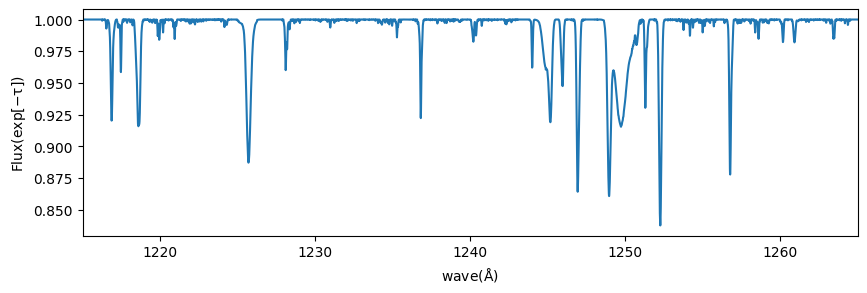

In [30]:
plt.figure(figsize = (10,3),dpi = 100)
plt.plot(wavelength,flux)
plt.xlim(1215,1265)
plt.xlabel('$\mathrm{wave(\AA)}$')
plt.ylabel('Flux($\mathrm{exp[-\\tau]}$)')

In [31]:
# add line spread function of COS
sg.apply_lsf()

yt : [INFO     ] 2022-03-30 19:49:03,113 Applying default line spread function for COS.


In [32]:
sg.save_spectrum('test_spec_lsf.h5')

yt : [INFO     ] 2022-03-30 19:49:03,869 Writing spectrum to hdf5 file: test_spec_lsf.h5.


In [33]:
f_spec = h5py.File('test_spec_lsf.h5')
wavelength = f_spec["wavelength"][:]
flux = f_spec['flux'][:]
f_spec.close()

Text(0, 0.5, 'Flux($\\mathrm{exp[-\\tau]}$)')

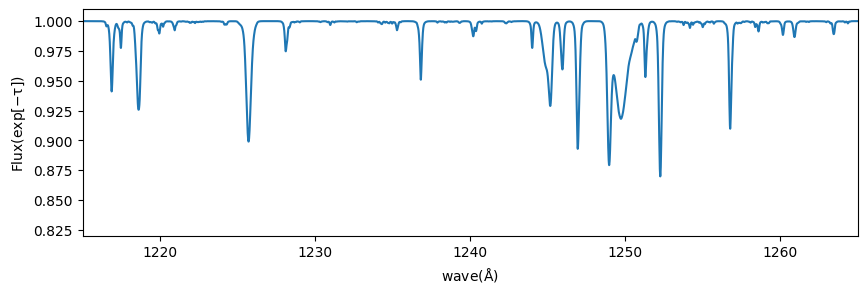

In [34]:
plt.figure(figsize = (10,3),dpi = 100)
plt.plot(wavelength,flux)
plt.xlim(1215,1265)
plt.ylim(0.82,1.01)
plt.xlabel('$\mathrm{wave(\AA)}$')
plt.ylabel('Flux($\mathrm{exp[-\\tau]}$)')

In [35]:
# add guassian noise
sg.add_gaussian_noise(30)

In [36]:
sg.save_spectrum('test_spec_lsf_noise30.h5')

yt : [INFO     ] 2022-03-30 19:49:24,725 Writing spectrum to hdf5 file: test_spec_lsf_noise30.h5.


In [37]:
f_spec = h5py.File('test_spec_lsf_noise30.h5')
wavelength = f_spec["wavelength"][:]
flux = f_spec['flux'][:]
f_spec.close()

In [38]:
f_spec30 = h5py.File('test_spec_lsf_noise30.h5')
wavelength30 = f_spec30["wavelength"][:]
flux30 = f_spec30['flux'][:]
f_spec30.close()

Text(0, 0.5, 'Flux($\\mathrm{exp[-\\tau]}$)')

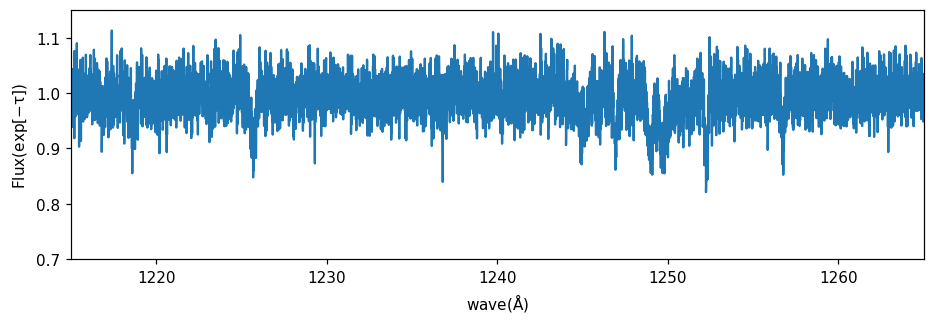

In [39]:
plt.figure(figsize = (10,3),dpi = 110)
plt.plot(wavelength30,flux30)
plt.xlim(1215,1265)
plt.ylim(0.7,1.15)
plt.xlabel('$\mathrm{wave(\AA)}$')
plt.ylabel('Flux($\mathrm{exp[-\\tau]}$)')